<a href="https://colab.research.google.com/github/prathyu-github/SchoolofAI---Assignments/blob/main/END2__06_Encoder_Decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

import spacy
import pandas as pd 
import random
import os, pickle
import matplotlib.pyplot as plt
import seaborn as sns
import time

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Data Preprocessing


In [ ]:
# Import and print samples of the dataset

from google.colab import drive
drive.mount('/content/drive/')
df= pd.read_csv("/content/drive/MyDrive/tweets.csv")
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,tweets,labels
0,Obama has called the GOP budget social Darwini...,1
1,"In his teen years, Obama has been known to use...",0
2,IPA Congratulates President Barack Obama for L...,0
3,RT @Professor_Why: #WhatsRomneyHiding - his co...,0
4,RT @wardollarshome: Obama has approved more ta...,1


In [ ]:
print("Shape of the data: ", df.shape)
print("Data value counts:")
print(df.labels.value_counts())

Shape of the data:  (1364, 2)
Data value counts:
0    931
1    352
2     81
Name: labels, dtype: int64


## Field Variables

In [ ]:
# Define text and target fields of the data
Tweet = data.Field(sequential = True,
                    tokenize = 'spacy',
                    batch_first =True,
                    include_lengths=True)

Label = data.LabelField(tokenize ='spacy',
                        is_target=True,
                        batch_first =True,
                        sequential =False)

fields = [('tweet', Tweet),('label', Label)]

## Create Dataset

In [ ]:
# Creating dataset
twitterDataset = data.TabularDataset(path="/content/drive/MyDrive/tweets.csv",
                                     format="CSV",
                                     fields=fields,
                                     skip_header=True)

# split the dataset into train and valid
(train, valid) = twitterDataset.split(split_ratio=[0.85, 0.15], random_state=random.seed(SEED))

print("Length of training data: ", len(train))
print("Length of validation data: ", len(valid))

Length of training data:  1159
Length of validation data:  205


In [ ]:
# print an example of the dataset
print(vars(train.examples[10]))

{'tweet': ['Even', 'CBS', 'wo', "n't", 'buy', 'bogus', 'WH', 'explanation', 'of', 'Obama', 'Supreme', 'Court', 'comments', '-', 'at', 'http://t.co/rkNdEmIy', '#', 'withnewt', '#', 'tpn', '#', 'tcot', '#', 'tlot', '#', 'tpp', '#', 'sgp'], 'label': '1'}


## Building Vocabulary

In [ ]:
MAX_VOCAB_SIZE = 5_000

Tweet.build_vocab(train, max_size = MAX_VOCAB_SIZE)
Label.build_vocab(train)

In [ ]:
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  4653
Size of label vocab :  3
Top 10 words appreared repeatedly : [('Obama', 1064), ('#', 798), (':', 780), ('.', 755), (',', 595), ('"', 558), ('the', 534), ('RT', 513), ('to', 398), ('?', 392)]
Labels :  defaultdict(None, {'0': 0, '1': 1, '2': 2})


## Create iterator objects

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_iterator, valid_iterator = data.BucketIterator.splits((train, valid),
                                                            batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweet),
                                                            sort_within_batch=True,
                                                            device = device)

Save the vocabulary for later use

In [ ]:
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

# Model Building

## Encoder

In [ ]:
class Encoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout):        
        super().__init__()              

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
                
    def forward(self, text, text_lengths, packed=False, debug=False, print_outputs=False):
        if debug:
          print("\nBefore entering embedding layer")
          print("Text shape: ", text.shape)
          print("Text length shape: ", text_lengths.shape)
          print("Text length: ", text_lengths)
          
        # text = [batch size, text_length]

        embedded = self.embedding(text)
        # embedded = [batch size, text_length, emb dim]

        if packed:
          print("Packed sequence selected...")
          embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)

        output, (hidden, cell) = self.encoder(embedded)
        # hidden = [num layers, batch size, hid dim]
        # cell = [num layers, batch size, hid dim]

        encoding = hidden.permute(1, 0, 2)
        # encoding = [batch_size, num_layers, hid_dim]

        if debug:
          print("Embedding shape: ", embedded.shape)
          if packed:
            print("Output shape: ", output.data.shape)
          else:
            print("Output shape: ", output.shape)    
          print("Hidden shape: ", hidden.shape)
          print("Cell shape: ", cell.shape)
          print("Encoding shape: ", encoding.shape)

        # Code to print the outputs at each step
        if print_outputs:          
          assert output.shape[0] == 1, \
            "Encoding at hidden states can only be printed for one tweet"

          print("\n")
          fig = plt.figure(figsize=(20, 8))
          for i in range(output.shape[1]):
            ax = fig.add_subplot(1, 4, i+1)            
            ax = sns.heatmap(output[0][i].detach().numpy().reshape(-1, 1), annot=True)
            ax.set(title=f"Encodings at Hidden State {i}")
          ax = fig.add_subplot(1, 4, i+2)
          ax = sns.heatmap(encoding.detach().numpy().reshape(-1, 1), annot=True)
          ax.set(title="Final Encoding Single Vector")
          plt.show()    

        return encoding, (hidden, cell)

## Decoder

In [ ]:
class Decoder(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):        
        super().__init__()     

        # LSTM layer
        self.decoder = nn.LSTM(input_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, input, hidden_states, debug=False, print_outputs=False):

        if debug:
          print("\nBefore entering decoder")
          print("Input shape: ", input.shape)
          print("Hidden states: ", len(hidden_states))

        hidden, cell = hidden_states
        output, (hidden, cell) = self.decoder(input)
        # hidden = [num layers, batch size, hid dim]
        # cell = [num layers, batch size, hid dim]

        if debug:          
          print("Output shape: ", output.shape)
          print("Hidden shape: ", hidden.shape)
          print("Cell shape: ", cell.shape)
        
        # Final dense layer
        dense_outputs = self.fc(hidden[0])
        if debug:          
          print("Dense outputs shape: ", dense_outputs.shape) 
        
        # Code to print the outputs at each step
        if print_outputs:          
          assert output.shape[0] == 1, \
            "Decoding at hidden states can only be printed for one tweet"
          
          print("\n")
          fig = plt.figure(figsize=(10, 8))
          for i in range(output.shape[1]):
            ax = fig.add_subplot(1, 2, i+1)            
            ax = sns.heatmap(output[0][i].detach().numpy().reshape(-1, 1), annot=True)
            ax.set(title=f"Decodings at Hidden State {i}")
          ax = fig.add_subplot(1, 2, i+2)
          ax = sns.heatmap(hidden.detach().numpy().reshape(-1, 1), annot=True)
          ax.set(title="Final Decoding sent to FC Layer")
          plt.show()  
            
        return dense_outputs

## Encoder-Decoder

In [ ]:
class Model(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, text, text_length, packed=False, debug=False, print_outputs=False):

    text, hidden_states = self.encoder(text,
                                       text_length,
                                       packed=packed,
                                       debug=debug,
                                       print_outputs=print_outputs)
    
    output = self.decoder(text,
                          hidden_states,
                          debug=debug,
                          print_outputs=print_outputs)

    return output

## Create the model object

In [ ]:
N_LAYERS = 1

ENC_INPUT_DIM = len(Tweet.vocab)
ENC_EMB_DIM = 256
ENC_HID_DIM = 25
ENC_DROPOUT = 0.2

DEC_INPUT_DIM = ENC_HID_DIM
DEC_HID_DIM = 25
DEC_OUTPUT_DIM = len(Label.vocab)
DEC_DROPOUT = 0.2

enc = Encoder(ENC_INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(DEC_INPUT_DIM, DEC_HID_DIM, DEC_OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = Model(enc, dec)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
print(model)

# No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

Model(
  (encoder): Encoder(
    (embedding): Embedding(4653, 256)
    (encoder): LSTM(256, 25, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (decoder): LSTM(25, 25, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=25, out_features=3, bias=True)
  )
)
The model has 1,224,746 trainable parameters


In [ ]:
# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# Train the model on GPU
model = model.to(device)
criterion = criterion.to(device)

# Train and Test Functions

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        # Retrieve text and no. of words
        tweet, tweet_length = batch.tweet

        predictions = model(tweet, tweet_length).squeeze(1)
        # predictions = model(batch.tweet)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# Evaluate the model on validation set
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            # Retrieve text and no. of words
            tweet, tweet_length = batch.tweet

            predictions = model(tweet, tweet_length).squeeze(1)
            # predictions = model(batch.tweet)

            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Model Training

In [ ]:
N_EPOCHS = 15

best_valid_loss = float('inf')

# Model training
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 1.084 | Train Acc: 55.91%
	 Val. Loss: 1.042 |  Val. Acc: 74.11%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 1.054 | Train Acc: 66.00%
	 Val. Loss: 0.998 |  Val. Acc: 75.00%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 1.025 | Train Acc: 67.77%
	 Val. Loss: 0.951 |  Val. Acc: 75.00%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.989 | Train Acc: 68.19%
	 Val. Loss: 0.901 |  Val. Acc: 75.00%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.949 | Train Acc: 67.86%
	 Val. Loss: 0.852 |  Val. Acc: 75.00%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.908 | Train Acc: 67.86%
	 Val. Loss: 0.800 |  Val. Acc: 75.00%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.867 | Train Acc: 68.19%
	 Val. Loss: 0.760 |  Val. Acc: 75.45%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.824 | Train Acc: 69.04%
	 Val. Loss: 0.730 |  Val. Acc: 75.45%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.784 | Train Acc: 69.21%
	 Val. Loss: 0.708 |  Val. Acc: 75.45%
Epoch: 10 | Epoch Time: 0m 0

In [ ]:
# Model testing
model.load_state_dict(torch.load('saved-model.pt'))

test_loss, test_acc = evaluate(model, valid_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.608 | Test Acc: 81.70%


# Encoder-Decoder Architecture Evaluation

In [ ]:
# load weights and tokenizer

path='./saved-model.pt'
model.load_state_dict(torch.load(path))
model.eval()
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

# inference 
nlp = spacy.load('en')

def classify_tweet(tweet):
    
    categories = {0: "Negative", 1: "Positive", 2: "Neutral"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                 
    prediction = model(tensor, length_tensor, debug=True, print_outputs=True).squeeze(1)
    _, pred = torch.max(prediction, 1) 
    
    return categories[pred.item()]


Before entering embedding layer
Text shape:  torch.Size([1, 3])
Text length shape:  torch.Size([1])
Text length:  tensor([3])
Embedding shape:  torch.Size([1, 3, 256])
Output shape:  torch.Size([1, 3, 25])
Hidden shape:  torch.Size([1, 1, 25])
Cell shape:  torch.Size([1, 1, 25])
Encoding shape:  torch.Size([1, 1, 25])




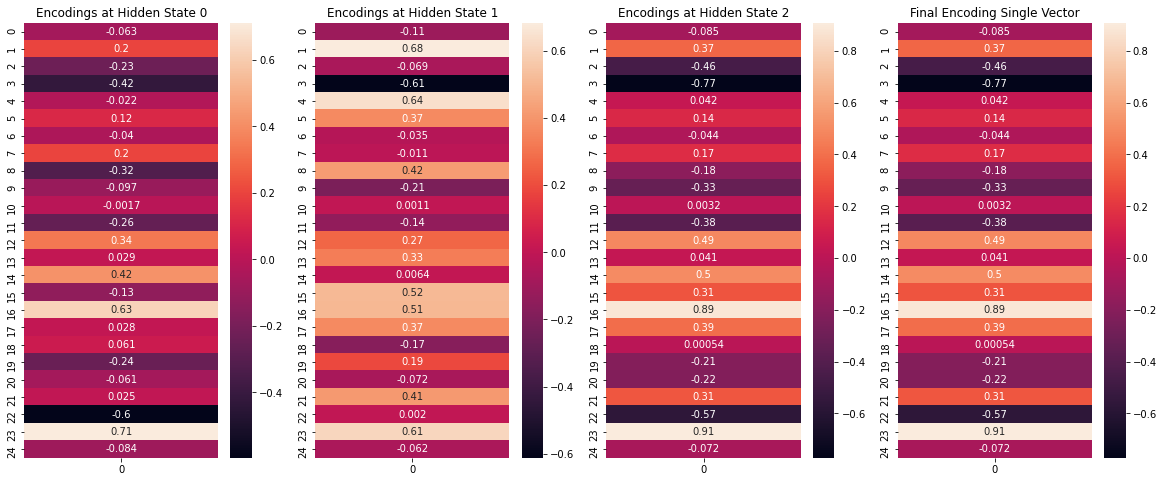


Before entering decoder
Input shape:  torch.Size([1, 1, 25])
Hidden states:  2
Output shape:  torch.Size([1, 1, 25])
Hidden shape:  torch.Size([1, 1, 25])
Cell shape:  torch.Size([1, 1, 25])
Dense outputs shape:  torch.Size([1, 3])




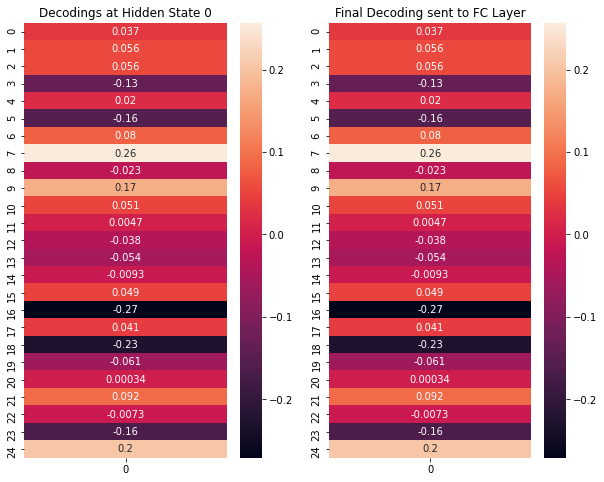

In [ ]:
pred = classify_tweet("print the outputs")

In [ ]:
print("Label predicted by the model: ", pred)

Label predicted by the model:  Negative
